### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
%matplotlib inline

import keras
import tensorflow
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten
from keras import backend
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
# Versioning
print(keras.__version__)
print(tensorflow.__version__)

2.2.4
1.10.0


### Read in Option Price Data set

In [3]:
#Pandas DataFrame
option_df = pd.read_pickle("option_data.pkl")
option_df.tail()

,Stock,Strike,Time,Volatility,Call Price
812245,198.0,161.163256,0.9,0.35,51.403603
812246,198.0,161.163256,0.9,0.40,53.938383
812247,198.0,161.163256,0.9,0.45,56.605515
812248,198.0,161.163256,0.9,0.50,59.364176
812249,198.0,161.163256,0.9,0.55,62.185912


### Normalize Data Set
The Black Scholes formula for a European call option is linearly homogenous with respect to the stock price ([see here](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=2ahUKEwiXi6iWhOneAhWOwFkKHexRCYsQFjAAegQICBAC&url=http%3A%2F%2Fwww.people.hbs.edu%2Frmerton%2Ftheory%2520of%2520rational%2520option%2520pricing.pdf&usg=AOvVaw3XyAFcxBFIywaszLIe5HfX)). Therfore we can normalize the data by dividing the price of the stock and the price of the call option by the strike price.

In [4]:
option_df['Stock'] = option_df['Stock'].div(option_df.Strike)
option_df['Call Price'] = option_df['Call Price'].div(option_df.Strike)
option_df['Strike'] = 1

## Write data to disk for future notebooks
option_df.to_pickle("opt_data_z.pkl")

In [5]:
option_df.head(10)

,Stock,Strike,Time,Volatility,Call Price
0,1.266988,1,0.1,0.10,0.271976
1,1.266988,1,0.1,0.15,0.271976
2,1.266988,1,0.1,0.20,0.271977
3,1.266988,1,0.1,0.25,0.272003
4,1.266988,1,0.1,0.30,0.272160
5,1.266988,1,0.1,0.35,0.272612
6,1.266988,1,0.1,0.40,0.273502
7,1.266988,1,0.1,0.45,0.274906
8,1.266988,1,0.1,0.50,0.276841
9,1.266988,1,0.1,0.55,0.279286


In [7]:
## Move data into numpy array
prices = option_df.values


#### Determine Train/Test Split

In [8]:
# X values
X = prices[:,:4]

# Y values 
y = prices[:,4:5]

# Use Sklearn library to randomly split data into training/testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



#### Build Keras Model

In [9]:
## Number/type of hyperparameters(i.e., nodes, activation function, dropout, layers) are explored in a different notebook
## The following architecture is fairly generic and can be found in most tutorials on regression

## Number of nodes in Neural Network
nodes = 200

# Create Model
model = Sequential()

# Layer 1
model.add(Dense(nodes, input_shape=(4,))) 
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Layer 2
model.add(Dense(nodes)) 
model.add(Activation ('relu'))
model.add(Dropout(0.25))

# Layer 3
model.add(Dense(nodes))
model.add(Activation ('relu'))
model.add(Dropout(0.25))

# Layer 4 - Output Layer
model.add(Dense(1))
model.add(Activation('elu'))


#### Compile Model

In [10]:
## Different Optimizers are compared in companion notebook
model.compile(loss='mse',
        optimizer='rmsprop')

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               1000      
_________________________________________________________________
activation_1 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               40200     
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 200)               40200     
__________

#### Stop training if cost function (val_loss) using cross validation data fails to decrease

In [12]:
callbacks_list = [EarlyStopping(monitor = 'val_loss', patience = 1)]

#### Fit Model

In [13]:
model.fit(X_train, y_train, epochs = 10, batch_size = 128, validation_split = 0.1, verbose = 2, callbacks = callbacks_list)

Train on 584820 samples, validate on 64980 samples
Epoch 1/10
 - 65s - loss: 0.0019 - val_loss: 9.6073e-04
Epoch 2/10
 - 63s - loss: 8.3696e-04 - val_loss: 4.9381e-04
Epoch 3/10
 - 64s - loss: 7.0180e-04 - val_loss: 2.8708e-04
Epoch 4/10
 - 63s - loss: 6.1776e-04 - val_loss: 4.5431e-04


#### Use model to predict option price using test set

In [14]:
predictions = model.predict(X_test)

#### Compare predictions to actual values

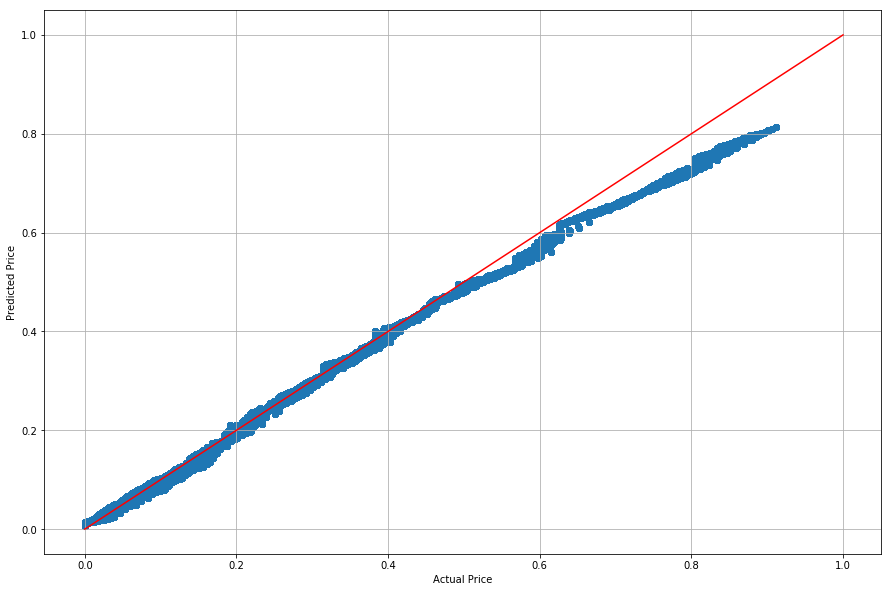

In [15]:
plt.figure(figsize = (15,10))
plt.scatter(y_test, predictions)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.plot([0,1], [0,1], 'r')
plt.grid(True)